# Imitate GaSe

パラメーター  
https://arxiv.org/ftp/arxiv/papers/1707/1707.01288.pdf
$m_v = -2.16$

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%run ./main.py
import matplotlib.pyplot as plt

# Started at Mon, 20 Jul 2020 15:42:13 +0900 JST
# ===========================
# Python version:  3.7.0 (default, Jun 28 2018, 13:15:42)  [GCC 7.2.0]
# API version:  1013
# Platform:  linux
# ===========================
# Elapse time for preparation:  0.0009405612945556641  [sec]
# Preparaiton is done
# ===========================
# Ended at Mon, 20 Jul 2020 15:42:13 +0900 JST


In [3]:
who

Atomfield	 Atomfluence	 Atomtime	 Atomvolume	 F2f	 Hartree	 Make_fields	 aB	 ch	 
chbar	 ct	 dcckt2cckt	 dcct2cct	 ekt2thetakt	 et2thetat	 f2F	 fpi	 get_J	 
get_dcckt	 get_dcct	 get_kpAt	 halfepsc	 k02k0pAt	 k2ec	 k2ev	 k2vc	 k2vv	 
math	 np	 parameter_class	 pi	 plt	 print_endtime	 print_footer	 print_header	 print_midtime	 
sol	 sys	 te	 time	 tpi	 ts	 tt	 zI	 


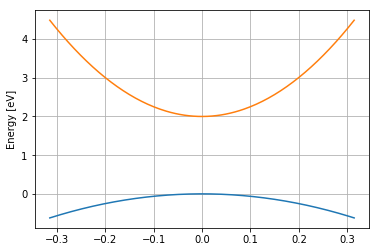

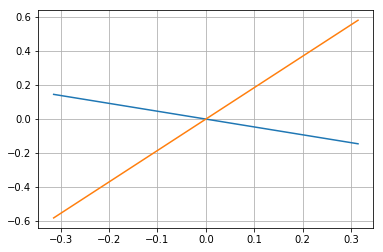

In [4]:
PC = parameter_class()
PC.Nk = 200
PC.mv = -2.16
PC.mc = -PC.mv/4.0 #Rough estimation from https://materialsproject.org/materials/mp-1943/
PC.Eg = 2.0/Hartree
PC.Make_kspace()
ev = k2ev(PC,PC.k)
ec = k2ec(PC,PC.k)
plt.figure()
plt.ylabel('Energy [eV]')
plt.plot(PC.k,ev*Hartree)
plt.plot(PC.k,ec*Hartree)
plt.grid()
plt.show()
#
vv = k2vv(PC,PC.k)
vc = k2vc(PC,PC.k)
plt.figure()
plt.plot(PC.k,vv)
plt.plot(PC.k,vc)
plt.grid()
plt.show()


tpi/dt 2.278435190310861  a.u.
Eg 0.07349864435130998  a.u.
0 200
100 200


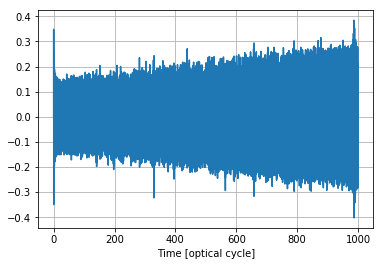

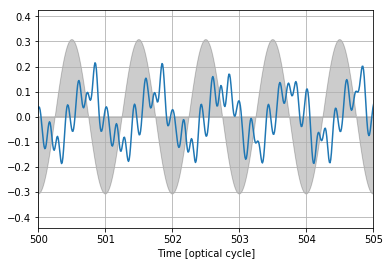

In [5]:
PC.Nt = 100000
PC.Ncycle = 1000
PC.omegac = 0.62/Hartree

PC.E0 = 1.0/Atomfield
t, A, E= Make_fields(PC)
print('tpi/dt',tpi/(t[1]-t[0]), ' a.u.')
print('Eg',PC.Eg, ' a.u.')
J = np.zeros(PC.Nt, dtype='complex128')
for ik in range(PC.Nk):
    k0pAt = k02k0pAt(PC, PC.k[ik], A)
    evt = k2ev(PC,k0pAt)
    ect = k2ec(PC,k0pAt)
    #print(evt.shape)
    #
    thetavt = et2thetat(PC, t, evt)
    thetact = et2thetat(PC, t, ect)
    #
    dcct = get_dcct(PC, thetavt, thetact, evt, ect, E)
    cct = dcct2cct(PC, t, dcct)
    #
    J[:] = J[:] + cct[:]* np.exp(zI*(thetavt[:] - thetact[:]))
    if (ik%100 == 0):
        print(ik, PC.Nk)
J = 2.0*np.real(J)/PC.Nk
plt.figure()
plt.xlabel('Time [optical cycle]')
plt.plot(t*PC.omegac/tpi,J)
plt.grid()
plt.show()
#
plt.figure()
plt.xlim(PC.Ncycle/2, PC.Ncycle/2+5.0)
plt.xlabel('Time [optical cycle]')
plt.plot(t*PC.omegac/tpi,J)
plt.fill_between(t*PC.omegac/tpi,E/np.amax(E)*0.8*np.amax(J),0.0*E,color='k',alpha=0.2)
plt.grid()
plt.show()

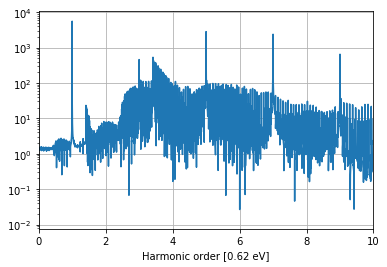

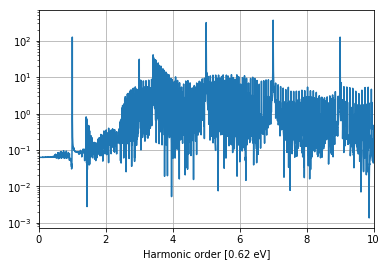

In [6]:
dt = t[1] - t[0]
omega = np.fft.fftfreq(PC.Nt)*(tpi/dt)
JF = np.fft.fft(J)
plt.figure()
plt.xlim(0.0,10.0)
plt.xlabel('Harmonic order ['+str(np.round(PC.omegac*Hartree, decimals=3))+' eV]')
plt.yscale('log')
plt.plot(omega[:PC.Nt//2]/PC.omegac,np.abs(JF[:PC.Nt//2]))
plt.grid()
plt.show()
a = F2f(t,J)
aF = np.fft.fft(a)
plt.xlim(0.0,10.0)
plt.xlabel('Harmonic order ['+str(np.round(PC.omegac*Hartree, decimals=3))+' eV]')
plt.yscale('log')
plt.plot(omega[:PC.Nt//2]/PC.omegac,np.abs(aF[:PC.Nt//2]))
plt.grid()
plt.show()



In [7]:
def f_Fourier_filter(t, f, ef_center, ef_width):
    eps = 1.0e-15
    dt = t[1] - t[0]
    omega = np.fft.fftfreq(PC.Nt)*(tpi/dt)
    fF = np.fft.fft(f)
    filt = np.exp(-(np.abs(omega) - ef_center)**2/ef_width**2) + eps
    #debub
    plt.figure()
    #plt.yscale('log')
    plt.plot(omega*Hartree,np.abs(fF))
    plt.plot(omega*Hartree,np.abs(filt*fF))
    plt.show()
    f_filter = np.fft.ifft(filt*fF)
    #
    plt.figure()
    plt.plot(t,np.real(f_filter),label='real')
    plt.plot(t,np.imag(f_filter),label='imag')
    plt.legend()
    plt.grid()
    plt.show()
    return np.real(f_filter)


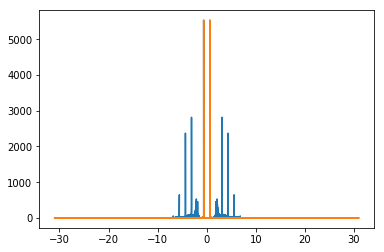

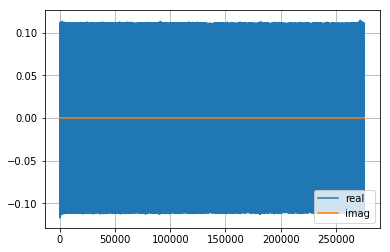

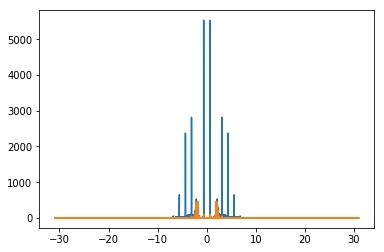

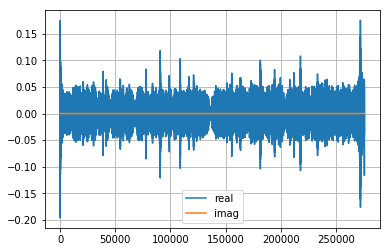

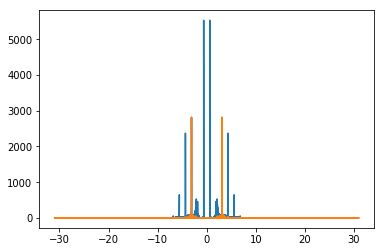

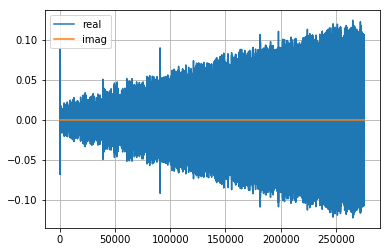

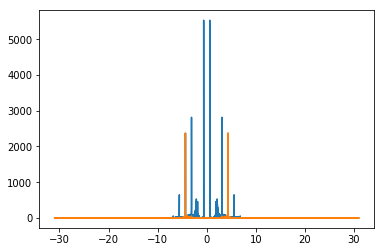

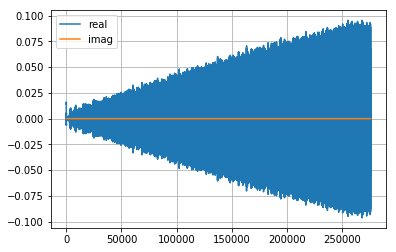

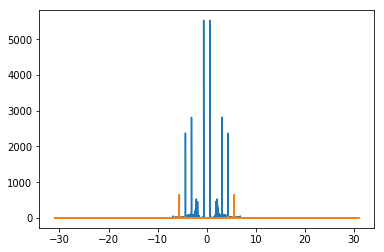

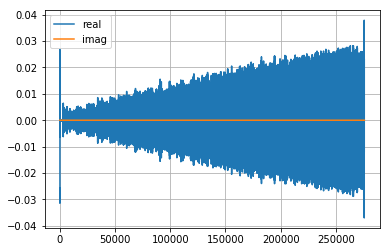

In [8]:
ef_center = 1.0*PC.omegac
ef_width = 1.0*PC.omegac
J1 =  f_Fourier_filter(t, J, ef_center, ef_width)
ef_center = 3.0*PC.omegac
J3 =  f_Fourier_filter(t, J, ef_center, ef_width)
ef_center = 5.0*PC.omegac
J5 =  f_Fourier_filter(t, J, ef_center, ef_width)
ef_center = 7.0*PC.omegac
J7 =  f_Fourier_filter(t, J, ef_center, ef_width)
ef_center = 9.0*PC.omegac
J9 =  f_Fourier_filter(t, J, ef_center, ef_width)
P1 = f2F(t,J1)
P1 = P1 - np.average(P1)
P3 = f2F(t,J3)
P3 = P3 - np.average(P3)
P5 = f2F(t,J5)
P5 = P5 - np.average(P5)
P7 = f2F(t,J7)
P7 = P7 - np.average(P7)
P9 = f2F(t,J9)
P9 = P9 - np.average(P9)

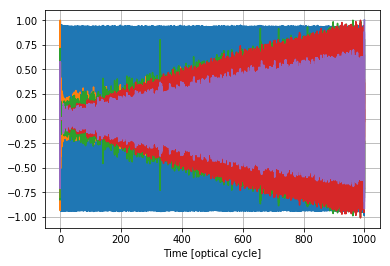

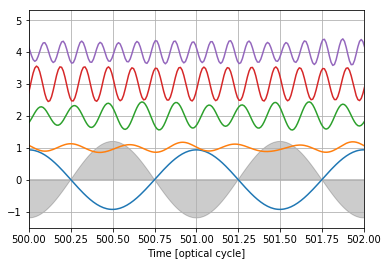

In [9]:
plt.figure()
plt.xlabel('Time [optical cycle]')
plt.plot(t*PC.omegac/tpi,P1/np.amax(P1),label='1')
plt.plot(t*PC.omegac/tpi,P3/np.amax(P3),label='3')
plt.plot(t*PC.omegac/tpi,P5/np.amax(P5),label='5')
plt.plot(t*PC.omegac/tpi,P7/np.amax(P7),label='7')
plt.plot(t*PC.omegac/tpi,P9/np.amax(P9),label='9')
plt.grid()
plt.show()
#
plt.figure()
plt.xlim(PC.Ncycle/2, PC.Ncycle/2+2.0)
plt.xlabel('Time [optical cycle]')
plt.plot(t*PC.omegac/tpi,P1/np.amax(P1),label='1')
plt.plot(t*PC.omegac/tpi,P3/np.amax(P3)+1.0,label='3')
plt.plot(t*PC.omegac/tpi,P5/np.amax(P5)+2.0,label='5')
plt.plot(t*PC.omegac/tpi,P7/np.amax(P7)+3.0,label='7')
plt.plot(t*PC.omegac/tpi,P9/np.amax(P9)+4.0,label='9')
plt.fill_between(t*PC.omegac/tpi,E/np.amax(E)*1.2,0.0*E,color='k',alpha=0.2)
plt.grid()
plt.show()